# Task 1: Exploratory Data Analysis (EDA)

## What is EDA ?
- In data science, EDA (Exploratory Data Analysis) is the crucial first step of analyzing datasets to discover patterns, spot anomalies, test hypotheses, and check assumptions, primarily using visualizations and summary statistics, to understand the data's core characteristics before formal modeling. It's the detective work that helps data scientists grasp the data's structure, identify errors, and decide how to best manipulate it for accurate insights, guiding feature selection and model building. 


## Question 1: Plot waveforms for each activity class

Plot the waveform for one sample data from each activity class. Analyze differences/similarities between the activities.

In [ ]:
import sys
sys.path.append('..')
from Assignment.HAR.MakeDataset import X_tr/my-university-archive
├── _quarto.yml          <-- The BRAIN (Global config)
├── index.qmd            <-- The Homepage (Welcome screen)
├── Assignment_01/
│   ├── Task1.ipynb
│   └── Task2.ipynb
└── Assignment_02/
    ├── Task1.ipynb
    └── Task2.ipynbain, y_train

# import os 
import matplotlib.pyplot as plt
import numpy as np

Activity_Classes = {1:'WALKING', 2:'WALKING_UPSTAIRS', 3:'WALKING_DOWNSTAIRS', 4:'SITTING', 5:'STANDING', 6:'LAYING'}

# X_train is 3D array: (# samples = (#activity x #subjects), # timesteps, # features = (3 : accx, accy, accz))
# we have 21 subjects for train data and 9 subjects for test data
# 6 activities

# X_train.shape = 21*6, 500, 3

# print(X_train.shape)
# open('X_train.txt', 'w').write(str(X_train))

Training data shape:  (126, 500, 3)
Testing data shape:  (54, 500, 3)


- Will plot acc data on y and time steps on x axis

- Data is SHUFFLED by train_test_split, so we need to use y_train to find samples by activity


X_train shape: (126, 500, 3)
y_train shape: (126,)


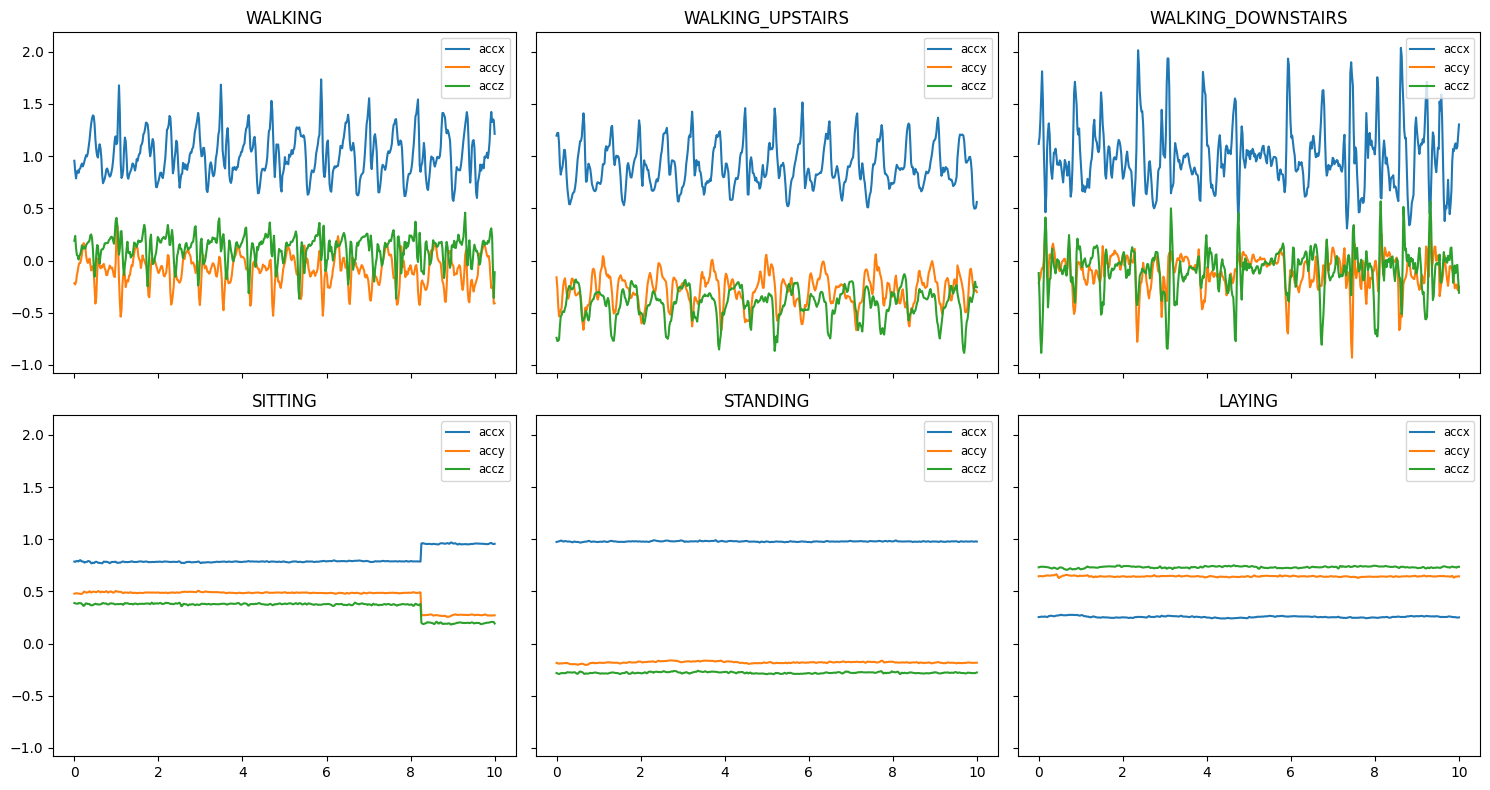

In [2]:
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

fig, axes = plt.subplots(2, 3, figsize=(15, 8), sharex=True, sharey=True)
t = np.linspace(0, 10, 500)

for cnt, (label_id, label_name) in enumerate(Activity_Classes.items()):
    axis = axes[cnt // 3, cnt % 3]
    
    # find first sample with this activity label
    idx = np.where(y_train == label_id)[0][0]
    
    x_axis = X_train[idx, :, 0]
    y_axis = X_train[idx, :, 1]
    z_axis = X_train[idx, :, 2]
    
    axis.plot(t, x_axis, label="accx")
    axis.plot(t, y_axis, label="accy")
    axis.plot(t, z_axis, label="accz")
    axis.set_title(label_name)
    axis.legend(loc='upper right', fontsize='small')

plt.tight_layout()
plt.show()

### Observations:

**Differences:**
- **Static activities** (SITTING, STANDING, LAYING): Show relatively flat, stable signals with minimal fluctuation
- **Dynamic activities** (WALKING, WALKING_UPSTAIRS, WALKING_DOWNSTAIRS): Show periodic oscillating patterns due to repetitive motion

**Similarities:**
- All static activities have similar low-variance patterns, making them harder to distinguish from each other
- Walking activities all show periodic patterns but with different frequencies and amplitudes

**Can the model classify activities?**
- **Yes**, the model should be able to distinguish between static and dynamic activities easily due to clear differences in variance/amplitude
- Distinguishing between different walking activities (upstairs vs downstairs) may be more challenging as patterns are similar
- Distinguishing between static activities (sitting vs standing vs laying) may also be challenging




---

## Question 2: Do you think we need a machine learning model to differentiate between static activities and dynamic activities?

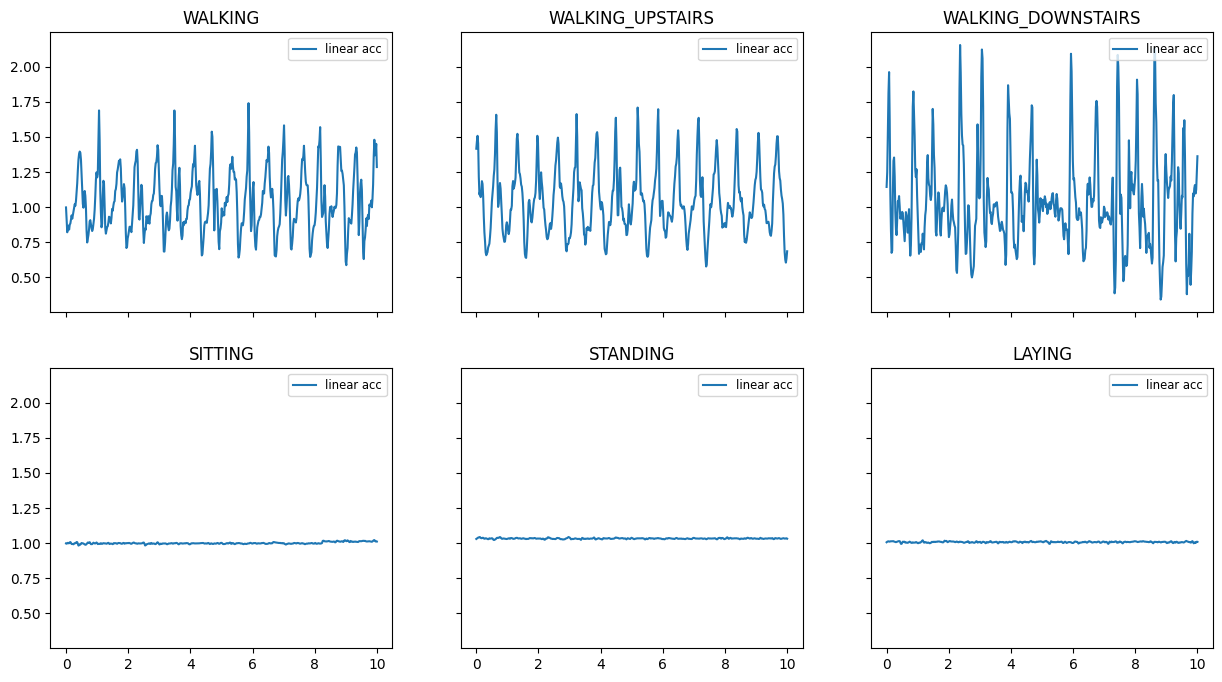

In [3]:
# linear acceleration

fig, axes = plt.subplots(2, 3, figsize=(15, 8), sharex=True, sharey=True)
t = np.linspace(0, 10, 500)

for cnt, (label_id, label_name) in enumerate(Activity_Classes.items()):
    axis = axes[cnt // 3, cnt % 3]
    
    # find first sample with this activity label
    idx = np.where(y_train == label_id)[0][0]
    
    x_axis = X_train[idx, :, 0]
    y_axis = X_train[idx, :, 1]
    z_axis = X_train[idx, :, 2]

    axis.plot(t, np.sqrt(x_axis**2+y_axis**2+z_axis**2), label="linear acc")
    axis.set_title(label_name)
    axis.legend(loc='upper right', fontsize='small')


## Ans:
**No**, we don't need a machine learning model to differentiate between static and dynamic activities.

**Justification:**
- For **static activities** , the total acceleration magnitude 
  $\sqrt{acc_x^2 + acc_y^2 + acc_z^2} \approx 1g$ and remains nearly constant (low variance), because the accelerometer only measures the acc due to gravity at stationary state

- For **dynamic activities**, the magnitude oscillates significantly (high variance)

A simple threshold-based rule on variance or standard deviation can reliably classify:

```if std(total_acc) > threshold = Dynamic, else = Static```

---

## Question 3: Visualize the data using PCA

Use Three methods for extracting important features - PCA on Tot_Acc, using TSFEL lib and then PCA, PCA on features provided by guys who made dataset itself :)

$accx^2 + accy^2 + accz^2 = Signal Energy$ (for magnitude we need sqrt)

### 1. PCA on Tot_Acc

- PCA on Total Acceleration: To compress the acceleration time series into 2 features (dimensions).

- PCA on the total Acc
    - There is 1 data sample (one recording window) of a person doing a single activity. This single sample contains 500 time steps (dimensions).
    - If we compress these 500 time steps down to 2 Principal Components (coordinates) $\rightarrow$ we get 2 numbers ($x, y$) that represent that entire recording.
    - This helps the human eye find patterns in a scatter plot.
        - Correction: It’s not that we had "500 dots" before. It is that we had 1 dot existing in a 500-dimensional invisible space. We physically cannot see 500 dimensions.
    
    - By compressing it to 2 dimensions, we can now project that 1 dot onto a flat 2D screen. This allows us to check if the "dots" for static activities (Sitting) are visibly separated from the "dots" for dynamic activities (Walking).

    - So this helps in EDA.

Method:
- Standardization ($\mu=0, \sigma=1$)
- Covariance Matrix
- Find Eigen Values and Vectors
- Sort and Select Comps
- Project the new onto new subspace (tranoformation $Y=XW$)

- AS we need to look at scatter plot for all activities we need a a shared coordinate system, so we dont have to do PCA for each activity, we need to convert whole dataset to new system of 2 features.

In [4]:
# using covaraiance matrix method as above is not used in data analysis bcz calculating covariance matrix for large datasets is computationally expensive and may not be feasible for real-time applications.
# so we use sklearn lib, which uses SVD method internally to compute principal components efficiently. wihtout needing the space and time complexity of covariance matrix calculation.

from sklearn.decomposition import PCA

squared = X_train**2
X_energy = np.sum(squared, axis=2) # axis=2 means summing along the feature axis (accx, accy, accz), as its zero based indexing 0,1,2


# open ('X_train_Tot_Acc.txt', 'w').write(str(X_train_Tot_Acc))
# print(X_train_Tot_Acc)
print(X_energy.shape)

pca = PCA(n_components=2)
X_reduced_m1 = pca.fit_transform(X_energy)

print(f"Shape of reduced data for plotting: {X_reduced_m1.shape}")

print(f"Variance explained by these 2 PCs: {pca.explained_variance_ratio_}")


(126, 500)
Shape of reduced data for plotting: (126, 2)
Variance explained by these 2 PCs: [0.10718737 0.08658314]


### Scatter Plot

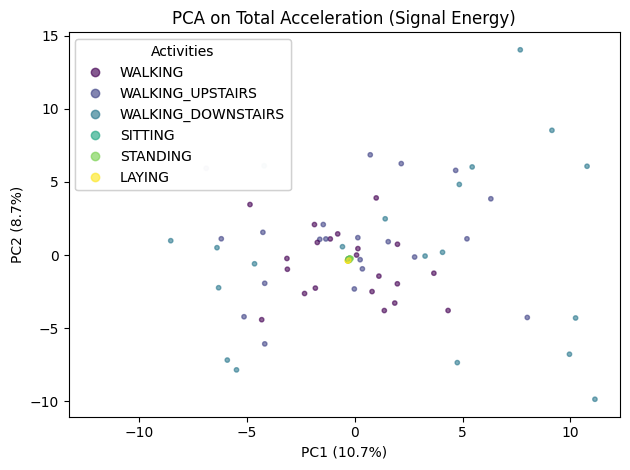

In [5]:
fig,axes = plt.subplots()
axis = axes

scatter = axis.scatter(X_reduced_m1[:, 0], X_reduced_m1[:, 1], c=y_train, cmap='viridis', alpha=0.6, s=10)
handles, _ = scatter.legend_elements()
activity_labels = [Activity_Classes[i] for i in sorted(Activity_Classes.keys())]
legend1 = axis.legend(handles, activity_labels, title="Activities")
axis.add_artist(legend1)

axis.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
axis.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
axis.set_title("PCA on Total Acceleration (Signal Energy)")

plt.tight_layout()
plt.show()

### 2. Using TSFEL and then PCA

- Instead of feeding raw numbers for PCA, we calculate statistics (features) like Mean, Variance, Entropy, Zero-Crossing Rate, FFT Peak. They are much better at distinguishing overlapping activities rather than raw data (we can see that the 3 activities of standing,;laying and sitting overlaped almost into single point due to ~1g value ).

- Steps:
    - Data Serialization: TSFEL is designed for continuous streams and 2D space. We "unroll" our 3D dataset $(N, 500, 3)$ into a long 2D stream $(N \times 500, 3)$ and then use TSFEL's windowing function to reconstruct the samples.
    
    - Feature Extraction: We extract statistical features independently for each axis ($x, y, z$). (3 cols of pd dataframe). tsfel does this internally, calculates mean, variance etc for each column and then concatenates 3 cols to one wide row

    - Standardization (Critical): We mix features with vastly different physical units (e.g., Variance in $m^2/s^4$ vs. Mean in $m/s^2$). Without StandardScaler, PCA would be biased towards features with larger numerical magnitudes, ignoring potentially discriminative but smaller-valued features.

In [ ]:
import tsfel
import pandas as pd
from sklearn.preprocessing import StandardScaler

# prepare data
# convert (N, 500, 3) -> (N*500, 3)
# This creates one continuous stream of data.
X_flat = X_train.reshape(-1, 3)
df_stream = pd.DataFrame(X_flat, columns=['acc_x', 'acc_y', 'acc_z'])

"""
tsfel config
 - define which features to extract.
 - 'statistical' includes mean, var, kurtosis, etc.
 - 'temporal' includes slope, zero-crossing, etc.
"""

cfg = tsfel.get_features_by_domain('statistical') 
# 'temporal' and 'spectral' needs more CPU and time which i dont have

# feature extract
# window_size=500 and overlap=0 to exactly reconstruct our original samples.
# fs=50 -> sampling freq (50Hz).
X_tsfel = tsfel.time_series_features_extractor(
    cfg, 
    df_stream, 
    fs=50, 
    window_size=500, 
    overlap=0, 
    verbose=0
)

print(f"Feature extraction complete. New shape: {X_tsfel.shape}")
# check for NaNs (sometimes features like FFT fail on constant data)
X_tsfel = X_tsfel.fillna(0)

# standardize
scaler = StandardScaler()
X_tsfel_scaled = scaler.fit_transform(X_tsfel)

In [96]:
# print(X_tsfel.columns)# print names of columns/features

- Now PCA and Plot

Variance explained (TSFEL): [0.53081705 0.19143562]


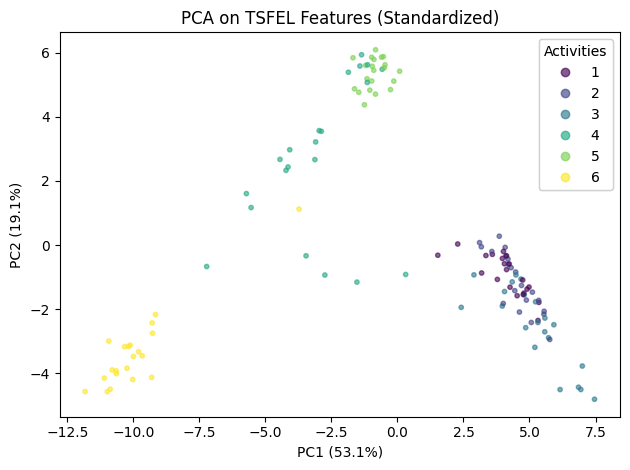

In [92]:
pca_tsfel = PCA(n_components=2)
X_tsfel_reduced = pca_tsfel.fit_transform(X_tsfel_scaled)

print(f"Variance explained (TSFEL): {pca_tsfel.explained_variance_ratio_}")

fig, ax = plt.subplots()
scatter = ax.scatter(X_tsfel_reduced[:, 0], X_tsfel_reduced[:, 1], 
                     c=y_train, cmap='viridis', alpha=0.6, s=10)

legend1 = ax.legend(*scatter.legend_elements(), title="Activities")
ax.add_artist(legend1)
ax.set_title("PCA on TSFEL Features (Standardized)")
ax.set_xlabel(f"PC1 ({pca_tsfel.explained_variance_ratio_[0]*100:.1f}%)")
ax.set_ylabel(f"PC2 ({pca_tsfel.explained_variance_ratio_[1]*100:.1f}%)")

plt.tight_layout()
plt.show()

### 3. PCA on Features provided by the guys who made the dataset (X_train.txt)


(7352, 561) (7352,)
X_reduced shape (7352, 2)


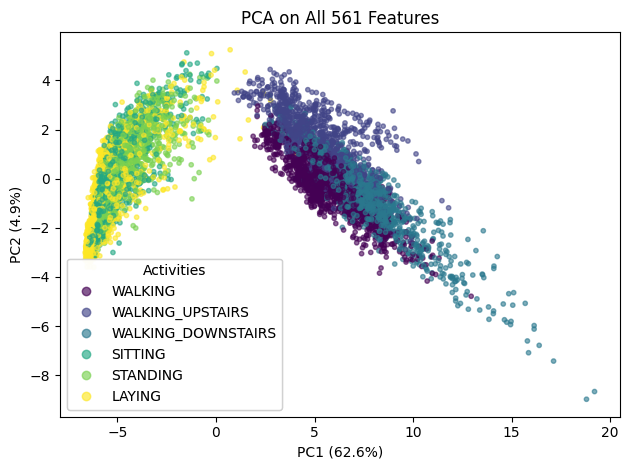

In [8]:
# path = '../human+activity+recognition+using+smartphones/UCI HAR Dataset/features.txt'

# with open(path, 'r') as f:
# 		data = f.readlines()

pathX="../human+activity+recognition+using+smartphones/UCI HAR Dataset/train/X_train.txt"
pathY="../human+activity+recognition+using+smartphones/UCI HAR Dataset/train/y_train.txt"

dataset_X_train = np.loadtxt(pathX)
dataset_y_train = np.loadtxt(pathY)

print(dataset_X_train.shape, dataset_y_train.shape)
# 561 columns -> of 561 features. each column has value of that feature for all the samples. dataset_y_train has integers for each row range from 1 to 6 denoting which activity class the sample belong to. so now you know what to do :)
pca = PCA(n_components=2)
#X_train is already in (n_samples, n_features) format, 2D array, so direct pca now
X_reduced_m3 = pca.fit_transform(dataset_X_train)
print("X_reduced shape",X_reduced_m3.shape)

fig,axes = plt.subplots()
axis=axes
scatter = axis.scatter(X_reduced_m3[:, 0], X_reduced_m3[:, 1], c=dataset_y_train, cmap='viridis', alpha=0.6, s=10)
handles, _ = scatter.legend_elements()
activity_labels = [Activity_Classes[i] for i in sorted(Activity_Classes.keys())]
legend1 = axis.legend(handles, activity_labels, title="Activities", loc='lower left')
axis.add_artist(legend1)
axis.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
axis.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
axis.set_title("PCA on All 561 Features")
plt.tight_layout()
plt.show()


- We can see that static and dynamic activities are seperated much more effectively. Also notice that the 3 class of activities in dynamic class are also being seperated nicely. So now we will analyse which features contributed most to the PC1 and PC2 and analyse which features played major role in distiguishing the classes more precisely

In [9]:
path = '../human+activity+recognition+using+smartphones/UCI HAR Dataset/features.txt'

features_df = pd.read_csv(path, sep='\s+', header=None, names=['idx', 'name'])
feature_names = features_df['name'].values

print(f"Loaded {len(feature_names)} feature names.")
print(pca.components_.shape)
# analysing weights of features in PCs
# pca.components_ -> (n_components, n_features) -> (2, 561)
# row 0 = weights for PC1, row 1 = weights for PC2

print("\n--- PC1 Interpretation ---")
# abs val of weights , no need to direction
pc1_weights = np.abs(pca.components_[0])

# specific trick: argsort gives indices of sorted values. [-5:] takes top 5. [::-1] reverses to descending.
top_5_pc1_idx = pc1_weights.argsort()[-5:][::-1]

for idx in top_5_pc1_idx:
    print(f"Feature '{feature_names[idx]}' weight: {pc1_weights[idx]:.4f}")


print("\n--- PC2 Interpretation ---")
pc2_weights = np.abs(pca.components_[1])
top_5_pc2_indices = pc2_weights.argsort()[-5:][::-1]

for idx in top_5_pc2_indices:
    print(f"Feature '{feature_names[idx]}' weight: {pc2_weights[idx]:.4f}")

Loaded 561 feature names.
(2, 561)

--- PC1 Interpretation ---
Feature 'fBodyAccJerk-entropy()-X' weight: 0.1252
Feature 'fBodyAccJerk-entropy()-Y' weight: 0.1225
Feature 'tBodyAccJerkMag-entropy()' weight: 0.1206
Feature 'fBodyAcc-entropy()-X' weight: 0.1202
Feature 'fBodyAccMag-entropy()' weight: 0.1134

--- PC2 Interpretation ---
Feature 'tBodyGyroMag-entropy()' weight: 0.1611
Feature 'fBodyAcc-skewness()-Z' weight: 0.1563
Feature 'fBodyAcc-kurtosis()-Z' weight: 0.1457
Feature 'tBodyGyroMag-arCoeff()1' weight: 0.1374
Feature 'fBodyAcc-meanFreq()-Z' weight: 0.1296


<>:3: SyntaxWarning: invalid escape sequence '\s'
<>:3: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_21490/3602945237.py:3: SyntaxWarning: invalid escape sequence '\s'
  features_df = pd.read_csv(path, sep='\s+', header=None, names=['idx', 'name'])



### All plots together

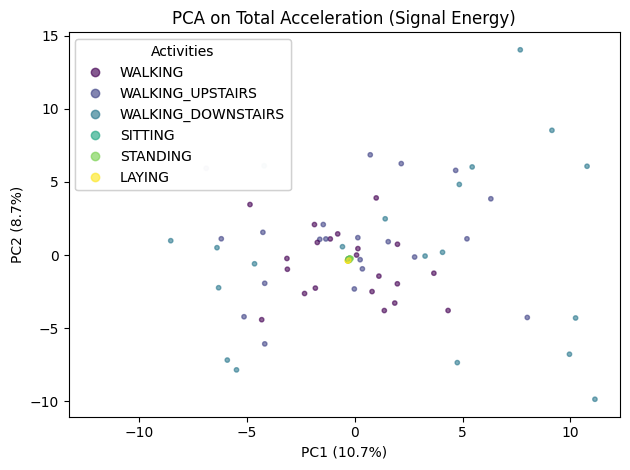
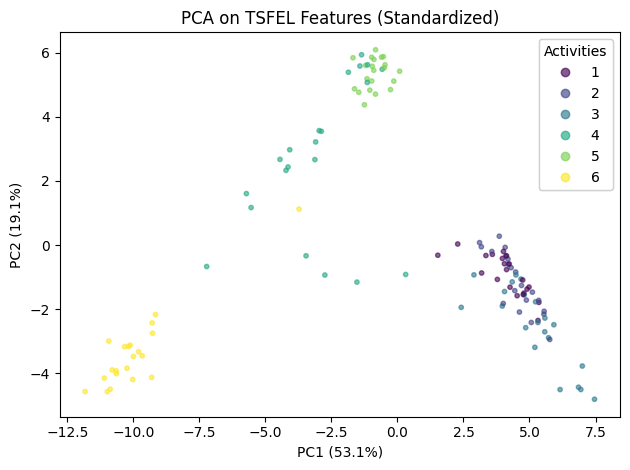
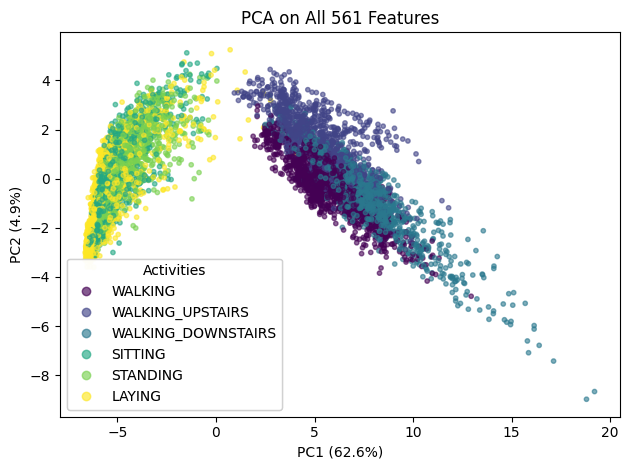

### 4. Which one is better from 3 methods?

- 1st methods of PCA on raw data, ditinguishes the static and dynamic activity pretty well, but does not distinguish intra subactivity classes
- 2nd method of PCA on TSFEL features , distinguishes between static and dynamic classes and also intra sub activity of static class, but for dynamix class all 3 are pretty much stacked together. It successfully isolates "Laying" from the other static activities (due to the "Mean" feature capturing the orientation change). However, it struggles to distinguish "Sitting" from "Standing" as their statistical profiles are nearly identical.

- 3rd method of PCA on features by dataset providers ditinguishes between static and dynamic classes and also intra sub activity of dynamic class, but for static class all 3 are stacked together


- in the third method we saw that 
    - PC1 was heavily affected by Jerk and Entropy so it sperated static and dynamic classes
    - PC2 was heavily affected by gyro and also by freq , so it seperated the intra dynamic subclasses very well. As walking upward and downward has diffrent gyro.

- So even though 3rd method should have better static subclass seperation, tsfel was better at distinguishing static subclasses. (that's what data is showing atleast :))

---

## Question 4: Correlation Matrix for features obtained by TSFEL and from Dataset. Identify the features that are highly correlated with each other. Are there any redundant features?

- dataset for tsfel features: X_tsfel
- dataset for dataset providers: dataset_X_train


- let highly corelated - 0.85 to 0.95
- redundant - corr > 0.95 -> this features are redundant because they provide similar information about the data. keeping both does not add significant value and may lead to overfitting in machine learning models.

In [22]:
print(X_tsfel.shape)
print(dataset_X_train.shape)

df1=pd.DataFrame(X_tsfel)
df2=pd.DataFrame(dataset_X_train)

corr_matrix_1 = df1.corr().abs()
# print(corr_matrix_1) #93x93
corr_matrix_2 = df2.corr().abs()
# print(corr_matrix_2) #516x516

(126, 93)
(7352, 561)


In [ ]:
# usinf heatmap is redundant as correlation matrix is large
# so need programatic way to find

# import seaborn as sns
# sns.heatmap(corr_matrix_1, cmap='rocket')
# sns.heatmap(corr_matrix_2, cmap='rocket')

In [ ]:
#upper triangle matrix with all zero below 1st diagonal (so that diagonal=0, as self corr=1, we need to ignore that)
temp = np.triu(corr_matrix_1,k=1)
# abs corr values
india = np.where((temp >= 0.85) & (temp <= 0.95))
print(india[0].shape)

high_corr_1 = np.zeros((india[0].shape[0],3))
for i in range(india[0].shape[0]):
    high_corr_1[i] = [india[0][i], india[1][i], temp[india[0][i], india[1][i]]]

#sort
sorted_indices = np.argsort(high_corr_1[:, 2])[::-1]

high_corr_1 = high_corr_1[sorted_indices]

print("Top 10 highly correlated feature pairs in TSFEL features:")
for i in range(10):
    print(f"{high_corr_1[i,2]:.4f} : [{X_tsfel.columns[int(high_corr_1[i,0])]} , {X_tsfel.columns[int(high_corr_1[i,1])] }]")

(112,)
Top 10 highly correlated feature pairs in TSFEL features:
0.9497 : [acc_x_Median absolute deviation , acc_x_Peak to peak distance]
0.9489 : [acc_z_Mean absolute deviation , acc_z_Variance]
0.9471 : [acc_y_Median absolute deviation , acc_y_Standard deviation]
0.9468 : [acc_x_Interquartile range , acc_x_Variance]
0.9463 : [acc_y_Mean absolute deviation , acc_y_Peak to peak distance]
0.9460 : [acc_z_ECDF Percentile_0 , acc_z_Min]
0.9454 : [acc_x_Peak to peak distance , acc_y_Peak to peak distance]
0.9428 : [acc_y_ECDF Percentile_0 , acc_y_Min]
0.9423 : [acc_x_ECDF Percentile_0 , acc_x_Mean]
0.9421 : [acc_y_Mean absolute deviation , acc_y_Median absolute deviation]


In [107]:
temp1=np.triu(corr_matrix_2,k=1)
india1 = np.where((temp1 >= 0.85) & (temp1 <= 0.95))
print(india1[0].shape)

high_corr_2 = np.zeros((india1[0].shape[0],3))
for i in range(india1[0].shape[0]):
    high_corr_2[i] = [india1[0][i], india1[1][i], temp1[india1[0][i], india1[1][i]]]
sorted_indices = np.argsort(high_corr_2[:, 2])[::-1]
high_corr_2 = high_corr_2[sorted_indices]
print("Top 20 highly correlated feature pairs in All 561 features:")
for i in range(20):
    print(f"{high_corr_2[i,2]:.4f} : [{feature_names[int(high_corr_2[i,0])]} , {feature_names[int(high_corr_2[i,1])]}]")

(13866,)
Top 20 highly correlated feature pairs in All 561 features:
0.9500 : [tBodyGyroJerk-iqr()-Z , fBodyGyro-iqr()-Z]
0.9500 : [tBodyAccJerkMag-mean() , fBodyGyro-mean()-Z]
0.9500 : [tBodyAccJerkMag-sma() , fBodyGyro-mean()-Z]
0.9500 : [tBodyAccJerk-std()-X , fBodyGyro-sma()]
0.9500 : [tBodyAcc-sma() , tBodyAccJerkMag-mad()]
0.9499 : [tBodyAccJerk-max()-Y , fBodyAccJerk-iqr()-Y]
0.9499 : [tBodyAcc-mad()-X , fBodyAccJerk-sma()]
0.9499 : [tBodyAccJerk-std()-Y , tBodyGyroJerk-sma()]
0.9499 : [tBodyAccJerkMag-mad() , fBodyAcc-iqr()-Y]
0.9499 : [tBodyAccJerk-iqr()-Y , fBodyAccJerk-entropy()-Y]
0.9498 : [tBodyGyroMag-mean() , fBodyAcc-mad()-Y]
0.9498 : [tBodyGyroMag-sma() , fBodyAcc-mad()-Y]
0.9498 : [fBodyAcc-std()-Y , fBodyAcc-entropy()-X]
0.9498 : [fBodyAcc-mad()-Y , fBodyAccJerk-entropy()-Z]
0.9498 : [tBodyAcc-energy()-Y , fBodyAcc-bandsEnergy()-1,24]
0.9498 : [tBodyAccJerk-std()-Y , fBodyAccJerk-entropy()-X]
0.9498 : [fBodyAccJerk-sma() , fBodyGyro-mean()-Z]
0.9497 : [fBodyAccJerk-m

- Redundant Features

In [108]:
india2= np.where((temp >= 0.95) & (temp <= 1.0))
print(india2[0].shape)
redundant_corr_1=np.zeros((india2[0].shape[0],3))
for i in range(india2[0].shape[0]):
    redundant_corr_1[i] = [india2[0][i], india2[1][i], temp[india2[0][i], india2[1][i]]]
sorted_indices = np.argsort(redundant_corr_1[:, 2])[::-1]
redundant_corr_1 = redundant_corr_1[sorted_indices]
print("Top 20 redundant feature pairs in TSFEL features:")
for i in range(20):
    print(f"{redundant_corr_1[i,2]:.4f} : [{X_tsfel.columns[int(redundant_corr_1[i,0])]} , {X_tsfel.columns[int(redundant_corr_1[i,1])] }]")

(69,)
Top 20 redundant feature pairs in TSFEL features:
1.0000 : [acc_z_Absolute energy , acc_z_Average power]
1.0000 : [acc_x_Absolute energy , acc_x_Average power]
0.9985 : [acc_x_Mean absolute deviation , acc_x_Standard deviation]
0.9980 : [acc_z_Mean , acc_z_Median]
0.9980 : [acc_y_Mean , acc_y_Median]
0.9969 : [acc_z_Mean absolute deviation , acc_z_Standard deviation]
0.9964 : [acc_y_Mean absolute deviation , acc_y_Standard deviation]
0.9962 : [acc_y_Histogram mode , acc_y_Median]
0.9930 : [acc_x_Mean , acc_x_Median]
0.9929 : [acc_z_Histogram mode , acc_z_Median]
0.9920 : [acc_y_Histogram mode , acc_y_Mean]
0.9916 : [acc_z_ECDF Percentile_0 , acc_z_Mean]
0.9913 : [acc_y_ECDF Percentile_0 , acc_y_Mean]
0.9899 : [acc_x_Absolute energy , acc_x_Root mean square]
0.9899 : [acc_x_Average power , acc_x_Root mean square]
0.9893 : [acc_z_ECDF Percentile_0 , acc_z_Median]
0.9890 : [acc_x_Mean , acc_x_Root mean square]
0.9887 : [acc_x_Peak to peak distance , acc_x_Standard deviation]
0.9871 

In [109]:
india3 = np.where((temp1 >= 0.95) & (temp1 <= 1.0))
print(india3[0].shape)
redundant_corr_1=np.zeros((india3[0].shape[0],3))
for i in range(india3[0].shape[0]):
    redundant_corr_1[i] = [india3[0][i], india3[1][i], temp1[india3[0][i], india3[1][i]]]
sorted_indices = np.argsort(redundant_corr_1[:, 2])[::-1]
redundant_corr_1 = redundant_corr_1[sorted_indices]
print("Top 20 redundant feature pairs in All 561 features:")
for i in range(20):
    print(f"{redundant_corr_1[i,2]:.4f} : [{feature_names[int(redundant_corr_1[i,0])]} , {feature_names[int(redundant_corr_1[i,1])]}]")

(2281,)
Top 20 redundant feature pairs in All 561 features:
1.0000 : [fBodyBodyAccJerkMag-mean() , fBodyBodyAccJerkMag-sma()]
1.0000 : [fBodyBodyGyroJerkMag-mean() , fBodyBodyGyroJerkMag-sma()]
1.0000 : [tGravityAccMag-mean() , tGravityAccMag-sma()]
1.0000 : [tBodyAccMag-arCoeff()1 , tGravityAccMag-arCoeff()1]
1.0000 : [tBodyAccMag-arCoeff()2 , tGravityAccMag-arCoeff()2]
1.0000 : [tBodyAccMag-arCoeff()3 , tGravityAccMag-arCoeff()3]
1.0000 : [tBodyAccMag-std() , tGravityAccMag-std()]
1.0000 : [tBodyAccMag-arCoeff()4 , tGravityAccMag-arCoeff()4]
1.0000 : [fBodyAccMag-mean() , fBodyAccMag-sma()]
1.0000 : [tBodyAccMag-energy() , tGravityAccMag-energy()]
1.0000 : [tBodyAccMag-entropy() , tGravityAccMag-entropy()]
1.0000 : [tBodyAccMag-iqr() , tGravityAccMag-iqr()]
1.0000 : [tBodyAccMag-mad() , tGravityAccMag-mad()]
1.0000 : [tBodyAccMag-max() , tGravityAccMag-max()]
1.0000 : [tBodyAccMag-min() , tGravityAccMag-min()]
1.0000 : [tBodyAccMag-sma() , tGravityAccMag-mean()]
1.0000 : [tBodyAccMag